In [8]:
import os
import glob
import numpy as np
import rasterio
from rasterio.vrt import WarpedVRT
from rasterio.warp import calculate_default_transform, Resampling
from rasterio.merge import merge
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.plot import plotting_extent

# 1) PATHS AND SETTINGS
band_dir      = r"D:\1Research\2025\NOAA_SatHack\NBR\sentinel2_california_postfire"
nbr_tile_dir  = r"D:\1Research\2025\NOAA_SatHack\NBR\nbr_tiles2"
os.makedirs(nbr_tile_dir, exist_ok=True)

mosaic_fp     = r"D:\1Research\2025\NOAA_SatHack\NBR\nbr_mosaic2_1km.tif"
county_shp    = r"D:\1Research\2025\NOAA_SatHack\cb_2018_us_county_500k"

target_crs    = "EPSG:3310"        
tile_res      = 10                  
mosaic_res    = (1000, 1000)       

# 2) HELPER TO COMPUTE ONE TILE’S NBR
def compute_nbr(nir_fp, swir_fp, out_fp):
    # Open a VRT for each band, reprojected on the fly
    with rasterio.open(nir_fp) as src_nir, rasterio.open(swir_fp) as src_swir:
        transform, width, height = calculate_default_transform(
            src_nir.crs, target_crs, src_nir.width, src_nir.height, *src_nir.bounds, resolution=tile_res
        )
        meta = src_nir.meta.copy()
        meta.update({
            "crs": target_crs,
            "transform": transform,
            "width": width,
            "height": height,
            "count": 1,
            "dtype": "float32",
            "nodata": np.nan
        })

        # Read reprojected arrays
        with WarpedVRT(src_nir, crs=target_crs,
                       transform=transform, width=width, height=height,
                       resampling=Resampling.bilinear) as vrt_nir, \
             WarpedVRT(src_swir, crs=target_crs,
                       transform=transform, width=width, height=height,
                       resampling=Resampling.bilinear) as vrt_swir:

            arr_nir  = vrt_nir.read(1).astype("float32")
            arr_swir = vrt_swir.read(1).astype("float32")

        # Compute NBR and write tile
        nbr = (arr_nir - arr_swir) / (arr_nir + arr_swir)
        with rasterio.open(out_fp, "w", **meta) as dst:
            dst.write(nbr, 1)
    print(f"Wrote NBR tile: {os.path.basename(out_fp)}")

# 3) RUN PER-TILE NBR PROCESSING
b08_files = sorted(glob.glob(os.path.join(band_dir, "*_B08.tif")))
b12_files = sorted(glob.glob(os.path.join(band_dir, "*_B12.tif")))

for b08, b12 in zip(b08_files, b12_files):
    tile_id = os.path.basename(b08).split("_B08")[0]
    out_fp  = os.path.join(nbr_tile_dir, f"{tile_id}_NBR.tif")
    if not os.path.exists(out_fp):
        compute_nbr(b08, b12, out_fp)



C:\Users\saura\AppData\Local\Temp\ipykernel_15020\3688350983.py:58: RuntimeWarning: invalid value encountered in divide
  nbr = (arr_nir - arr_swir) / (arr_nir + arr_swir)


Wrote NBR tile: S2A_MSIL2A_20200825T185921_R013_T10SEH_20200827T175112_NBR.tif
Wrote NBR tile: S2A_MSIL2A_20200825T185921_R013_T10SEJ_20200827T175110_NBR.tif
Wrote NBR tile: S2A_MSIL2A_20200825T185921_R013_T10TCL_20200827T175102_NBR.tif
Wrote NBR tile: S2A_MSIL2A_20200825T185921_R013_T10TCM_20200827T175047_NBR.tif
Wrote NBR tile: S2A_MSIL2A_20200825T185921_R013_T10TDK_20200827T175109_NBR.tif
Wrote NBR tile: S2A_MSIL2A_20200825T185921_R013_T10TDL_20200918T171843_NBR.tif
Wrote NBR tile: S2A_MSIL2A_20200825T185921_R013_T10TDM_20200909T084101_NBR.tif
Wrote NBR tile: S2A_MSIL2A_20200825T185921_R013_T10TEL_20200827T175101_NBR.tif
Wrote NBR tile: S2A_MSIL2A_20200825T185921_R013_T10TEM_20200918T171901_NBR.tif
Wrote NBR tile: S2A_MSIL2A_20200825T185921_R013_T10TFK_20200827T175057_NBR.tif
Wrote NBR tile: S2A_MSIL2A_20200825T185921_R013_T10TFL_20200827T175055_NBR.tif
Wrote NBR tile: S2A_MSIL2A_20200825T185921_R013_T10TFM_20200827T175059_NBR.tif
Wrote NBR tile: S2A_MSIL2A_20200826T182921_R027_T11S

In [9]:
# 4) MOSAIC NBR TILES AT 1 KM USING SUM & COUNT TO COMPUTE AVERAGE
# Gather tile filepaths and open sources
nbr_tiles = glob.glob(os.path.join(nbr_tile_dir, "*_NBR.tif"))
srcs = [rasterio.open(fp) for fp in nbr_tiles]

# 1) mosaic of sums
sum_mosaic, trans = merge(srcs, res=mosaic_res, method="sum")

# 2) mosaic of counts
count_mosaic, _ = merge(srcs, res=mosaic_res, method="count")

# 3) average 
avg_mosaic = np.where(count_mosaic > 0,
                      sum_mosaic / count_mosaic,
                      np.nan)
avg_band   = np.squeeze(avg_mosaic)  

# Close inputs
for src in srcs:
    src.close()

# 4) write out the averaged mosaic
profile = srcs[0].profile.copy()
profile.update({
    "height": avg_band.shape[0],
    "width":  avg_band.shape[1],
    "transform": trans,
    "crs": target_crs,
    "count": 1,
    "dtype": "float32",
    "nodata": np.nan
})

with rasterio.open(mosaic_fp, "w", **profile) as dst:
    dst.write(avg_band, 1)

print("Wrote averaged 1 km NBR mosaic:", mosaic_fp)

Wrote averaged 1 km NBR mosaic: D:\1Research\2025\NOAA_SatHack\NBR\nbr_mosaic2_1km.tif


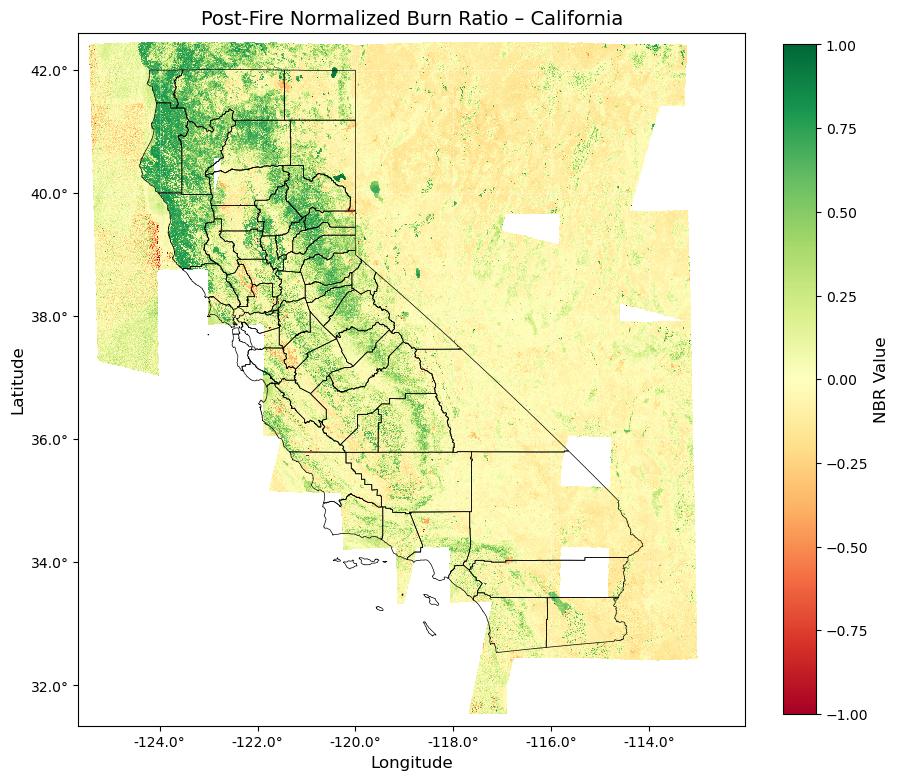

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from rasterio.vrt import WarpedVRT
from rasterio.plot import plotting_extent

# 5. PLOT THE MOSAIC WITH LAT/LON AXES
# Load and filter California counties, reproject to WGS84
counties = gpd.read_file(county_shp)
ca_counties = counties[counties["STATEFP"] == "06"].to_crs("EPSG:4326")

with rasterio.open(mosaic_fp) as src:
    # Create a virtual raster reprojected to EPSG:4326
    with WarpedVRT(src, crs="EPSG:4326") as vrt:
        arr = vrt.read(1)
        extent = plotting_extent(vrt)  

fig, ax = plt.subplots(figsize=(12, 9))

# Show the reprojected data
im = ax.imshow(
    arr,
    cmap="RdYlGn",
    vmin=-1, vmax=1,
    extent=extent,
    origin="upper",
    interpolation="none"
)

# Plot county boundaries in lon/lat
ca_counties.boundary.plot(
    ax=ax, edgecolor="black", linewidth=0.5
)

# Set titles and labels
ax.set_title("Post-Fire Normalized Burn Ratio – California", fontsize=14)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Ticks as degrees
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter("%.1f°"))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.1f°"))

# Add grid
ax.grid(True, linestyle="--", linewidth=0.4, color="white", alpha=0.7)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label("NBR Value", fontsize=12)

plt.savefig('post_fire.png', dpi = 300, bbox_inches = 'tight')
plt.show()
